# RNN para geração de moléculas

# Modelando dados sequenciais

Modelos sequenciais nos permitem abordar diferentes tipos de problemas!

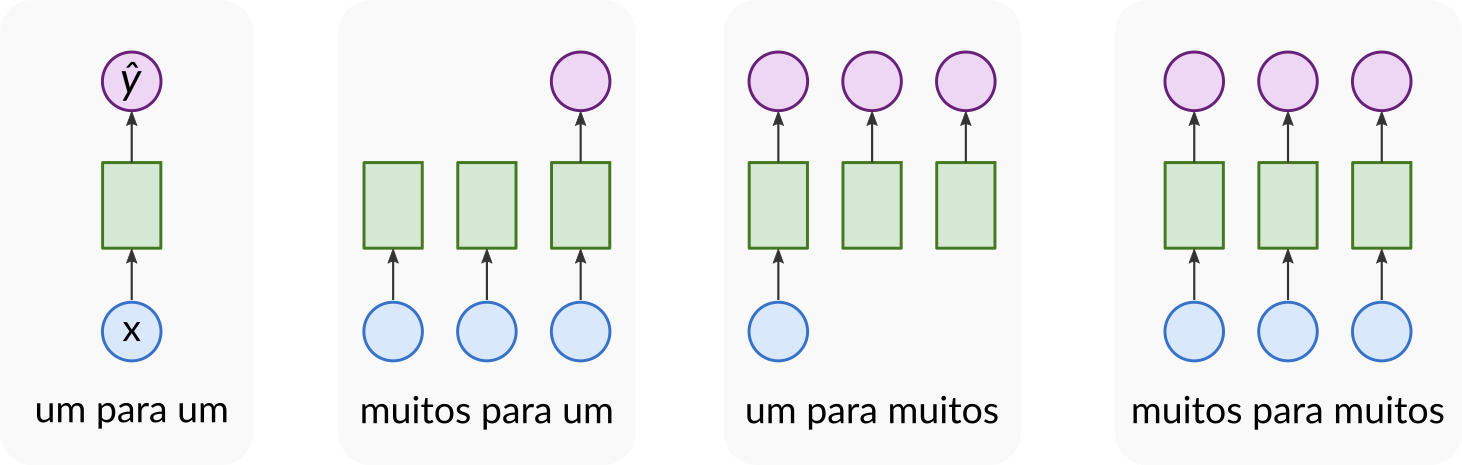

# Aspectos cruciais na modelagem de sequências

Na modelagem de sequências, é crucial:

* lidar com sequências de tamanho variável;
* considerar dependências de longo prazo;
* manter informação sobre a ordem;
* compartilhar parâmetros ao longo da sequência.

Paradigma da modelagem de sequências: como sair do modelo de processamento "tradicional" para o modelo sequencial?

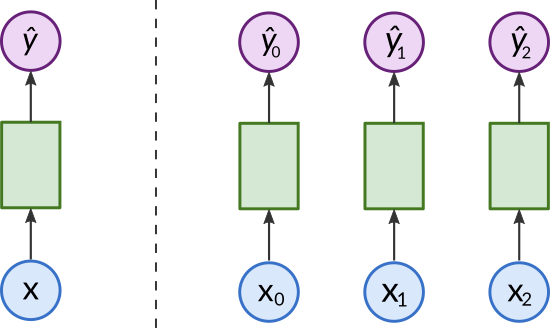

# Redes neurais recorrentes (RNNs)

Introduzimos com as [RNNs](https://www.youtube.com/watch?v=dqoEU9Ac3ek) a noção de recorrência.

Atualiza o vetor de estado:

$$h_t = g(\mathbf{W}^T_{hh}h_{t-1} + \mathbf{W}^T_{xh}x_t)$$

Produz o vetor de saída:

$$\hat{y}_t = \mathbf{W}^T_{hy} h_t$$

RNN "desenrolada" (*unrolled*) no tempo:


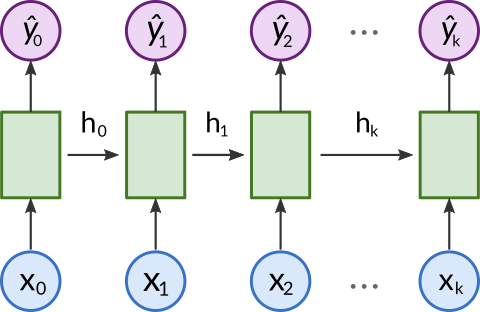


# RNN como modelos generativos

Podemos usar um modelo RNN treinado para gerar novas sequências, de uma maneira "autoregressiva":

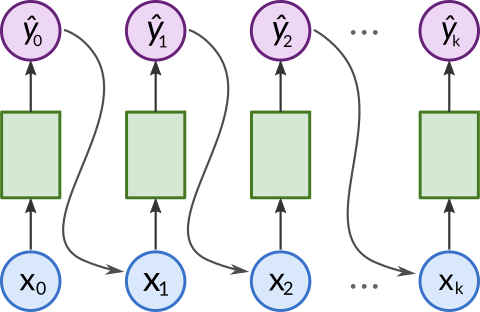

A função **[softmax](https://youtu.be/wjZofJX0v4M?si=x8DgJCkuF3Tp65Tp&t=1345)** converte um vetor em probabilidades:

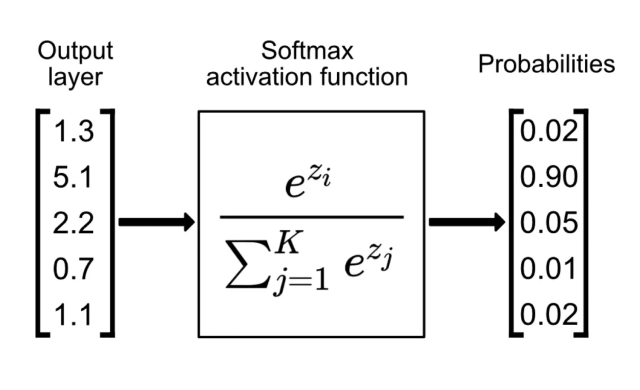

# Como calcular o "erro" em um modelo de linguagem?

Cálculo do erro ["através do tempo"](https://youtu.be/dqoEU9Ac3ek?si=RmzRIDJZPR-wiGDz&t=1910):

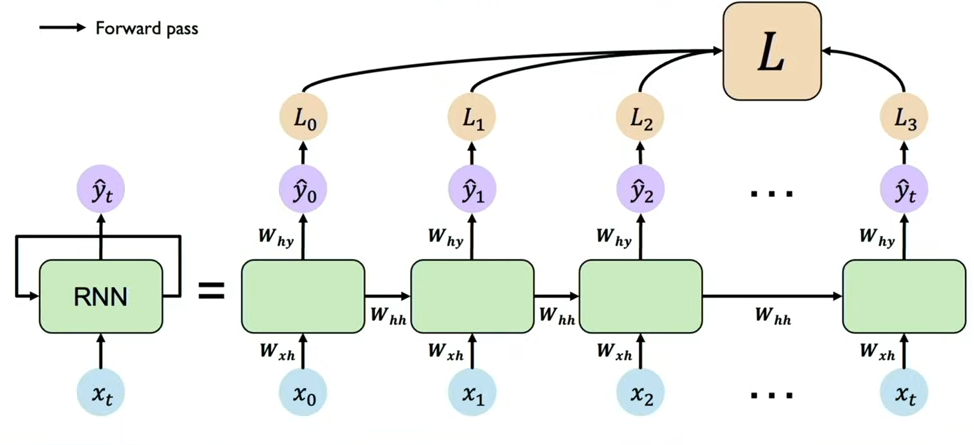

In [72]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import List
import numpy as np
from dataclasses import dataclass
from tqdm import tqdm

In [73]:
with open("smiles.txt") as f:
    dataset = f.read().splitlines()

In [74]:
len(dataset)

100000

In [75]:
train_data, test_data = train_test_split(
    dataset,
    shuffle=True,
    random_state=1984,
    test_size=.1
)

print(f"N. de exemplos train: {len(train_data):>10}",)
print(f"N. de exemplos valid: {len(test_data):>10}",)

N. de exemplos train:      90000
N. de exemplos valid:      10000


In [76]:
class Vocabulary:
    bos = "<bos>"  # beginning of a sentence
    eos = "<eos>"  # end of a sentence
    pad = "<pad>"  # pad token
    unk = "<unk>"  # unknown token

    def __init__(self, corpus: List):
        """Build a vocabulary from corpus of text."""
        if isinstance(corpus, np.ndarray):
            corpus = corpus.tolist()

        special_tokens = [self.pad, self.bos, self.eos, self.unk]
        self.vocabulary = special_tokens + sorted(set("".join(corpus)))
        self.char2idx = {u:i for i, u in enumerate(self.vocabulary)}  # char -> idx
        self.idx2char = np.array(self.vocabulary)  # idx -> char

    def string2vec(self, string: str, with_eos=False, with_bos=False) -> List[int]:
        """Convert string to its vector index representation."""
        (unk, eos, bos) = (self.char2idx[t] for t in [self.unk, self.eos, self.bos])
        vec = [self.char2idx.get(c, unk) for c in string]

        if with_bos:
            vec = [bos] + vec
        if with_eos:
            vec = vec + [eos]

        return np.array(vec)

    def vec2string(self, vec: List[int], remove_eos=False, remove_bos=False) -> str:
        """Convert vector of indexes to back to a string."""
        vec = vec[:]

        if remove_bos:
            while self.char2idx[self.bos] in vec:
                vec.remove(self.char2idx[self.bos])

        if remove_eos:
            while self.char2idx[self.eos] in vec:
                vec.remove(self.char2idx[self.eos])

        vec = [i for i in vec if i not in (self.char2idx[self.pad], self.char2idx[self.unk])]

        return "".join([self.idx2char[i] for i in vec])


In [77]:
class MoleculesDataset(Dataset):
    def __init__(self, dataset: List[str], vocabulary: Vocabulary):
        super(MoleculesDataset, self).__init__()
        self.dataset = dataset
        self.vocab = vocabulary

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx) -> torch.Tensor:
        item = self.dataset[idx]
        tensor = torch.tensor(
            self.vocab.string2vec(item, with_eos=True, with_bos=True),
            dtype=torch.long,
        )
        return tensor

    def get_collate_fn(self):
        pad = self.vocab.char2idx[self.vocab.pad]  # pad token idx

        def collate_fn(batch):
            """Collates a batch by formatting and padding sequences.

                Args:
                    batch: batch of tensors, each tensor an example of the dataset

            """
            inputs = pad_sequence([t[:-1] for t in batch], True, pad)
            targets = pad_sequence([t[1:] for t in batch], True, pad)
            lengths = torch.tensor(
                [len(t) - 1 for t in batch],
                dtype=torch.long,
            )

            return inputs, targets, lengths
        return collate_fn


In [78]:
vocab = Vocabulary(train_data)
vocab.string2vec('CCC1')

array([15, 15, 15,  8])

In [79]:
vocab = Vocabulary(dataset)
train_dataset = MoleculesDataset(train_data, vocab)
test_dataset = MoleculesDataset(test_data, vocab)

In [80]:
print(f"str: {train_data[0]} \nidx: {train_dataset[0].tolist()}")

str: O=C(COc1ccc(Cl)cc1Cl)Cc1ccncc1 
idx: [1, 19, 13, 15, 5, 15, 19, 23, 8, 23, 23, 23, 5, 15, 24, 6, 23, 23, 8, 15, 24, 6, 15, 23, 8, 23, 23, 25, 23, 23, 8, 2]


In [81]:
class Trainer:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __init__(self, config):
        self.config = config

    def _shared_step(self, inputs, targets, lens, loss_fn, model):
        """Handles the shared steps between training and evaluation."""
        inputs, targets = inputs.to(self.DEVICE), targets.to(self.DEVICE)
        output, _ = model(inputs, lens)
        loss = loss_fn(output.view(-1, output.shape[-1]), targets.view(-1))
        return loss

    def _evaluate(self, dataloader, model, loss_fn):
        """Evaluates the model on a dataset."""
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, targets, lens in dataloader:
                loss = self._shared_step(inputs, targets, lens, loss_fn, model)
                total_loss += loss.item()
        return total_loss / len(dataloader)

    def _train_epoch(self, dataloader, model, loss_fn, optimizer):
        """Trains the model for one epoch."""
        model.train()
        total_loss = 0
        for inputs, targets, lens in dataloader:
            loss = self._shared_step(inputs, targets, lens, loss_fn, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def _train(self, model, train_dataloader, valid_dataloader):
        """Handles the overall training process."""
        loss_fn = torch.nn.NLLLoss()
        optimizer = eval(self.config.optim)(model.parameters(), lr=self.config.lr)
        logs = {"loss": [], "val_loss": []}

        for epoch in range(self.config.epochs):
            tqdm_train = tqdm(train_dataloader, unit="batch", desc=f"Epoch {epoch + 1}")
            train_loss = self._train_epoch(tqdm_train, model, loss_fn, optimizer)
            logs["loss"].append(train_loss)

            if valid_dataloader:
                tqdm_valid = tqdm(valid_dataloader, unit="batch", desc="Validation")
                val_loss = self._evaluate(tqdm_valid, model, loss_fn)
                logs["val_loss"].append(val_loss)

        return logs

    def fit(self, model, train_dataset, valid_dataset=None):
        """Trains the model and returns the training logs."""
        model = model.to(self.DEVICE)
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            collate_fn=train_dataset.get_collate_fn(),
            shuffle=self.config.shuffle,
            num_workers=self.config.num_workers,
        )

        valid_dataloader = None
        if valid_dataset:
            valid_dataloader = DataLoader(
                valid_dataset,
                batch_size=self.config.batch_size,
                collate_fn=train_dataset.get_collate_fn(),
                shuffle=False,
                num_workers=self.config.num_workers,
            )

        return self._train(model, train_dataloader, valid_dataloader)


In [82]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, lengths, hidden_state=None):
        # Embedding layer
        embedded = self.embedding(x)

        # Pack the sequence of embeddings, required for RNNs
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)

        # RNN layer
        packed_output, hidden_state = self.rnn(packed_embedded, hidden_state)

        # Unpack the output
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Apply the linear layer to each timestep's output
        output = self.fc(output)

        # Apply the softmax on the last output of each sequence
        # The output is of shape (batch_size, seq_length, output_dim)
        # We'll use the last output for the classification, which is at position [-1, :]
        output = self.softmax(output)

        return output, hidden_state


In [83]:
@dataclass
class Config:
    batch_size: int = 128
    lr: float = 1e-4
    optim: str = "torch.optim.Adam"
    epochs: int = 2
    shuffle: bool = True
    num_workers: int = 2
    vocab_size = len(vocab.vocabulary)
    embedding_dim = 128
    hidden_dim = 128
    output_dim = len(vocab.vocabulary)

In [84]:
config = Config()
model = SimpleRNN(config.vocab_size, config.embedding_dim, config.hidden_dim, config.output_dim)
trainer = Trainer(config)

logs = trainer.fit(model, train_dataset, test_dataset)

Validation: 100%|██████████| 79/79 [00:00<00:00, 109.89batch/s]


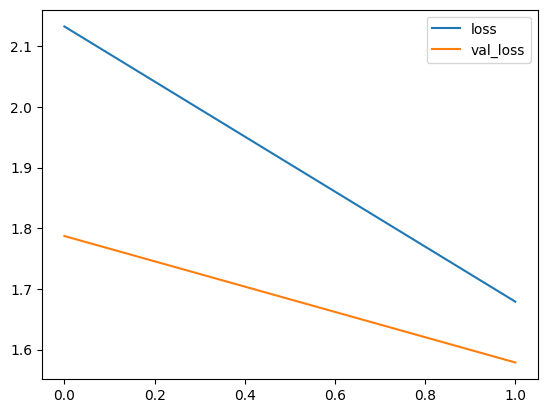

In [85]:
# prompt: plot loss and val_loss from the logs dictionary

import matplotlib.pyplot as plt

plt.plot(logs['loss'], label='loss')
plt.plot(logs['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [86]:
def sample_smiles(model, vocab, n_samples=2):
    """Generate SMILES samples."""
    initial_char = vocab.char2idx[vocab.bos]
    initial_vec = torch.tensor([initial_char], device=Trainer.DEVICE, dtype=torch.long)

    model.eval()
    smiles = list()
    with torch.no_grad():
        for _ in tqdm(range(n_samples)):
            sample = [initial_char]
            out = torch.unsqueeze(initial_vec, dim=0)  # match input dimension
            hidden = None

            while sample[-1] != vocab.char2idx[vocab.eos]:
                out = model.embedding(out)
                out, hidden = model.rnn(out, hidden)
                out = model.fc(out)
                out = model.softmax(out)

                pred_idx = torch.multinomial(out.squeeze().exp(), 1)
                sample.append(pred_idx[0].item())

                out = torch.unsqueeze(pred_idx, dim=0)

            smiles.append(vocab.vec2string(sample, remove_eos=True, remove_bos=True))

    return smiles



In [87]:
sample_smiles(model, vocab, n_samples=10)

100%|██████████| 10/10 [00:00<00:00, 61.88it/s]


['CcBnn2CCO2(NC(C)s1)',
 'Cn1c(F)c(NS(=O)NC(=O)NCCC1',
 'CC1',
 'CC(S(=O)NC23c1Cc(=O)N(C)nc2cccc(F)c(=O)OC)c(N)c1CC(CC(=)CC(=O)NC(=O)c1ccccc2)Fc1ccc(c2ccncnS3)F',
 'COC(CCOC(=O)COc3ccc(CC)c2)c(NC(=O)2)cc1-c1cc2C',
 'Cc1cccs1',
 'COCCn1cn(-c2ccccc2)c1c(=O)c1c',
 'O=C(NCC3C(=O)c1cccc(NC)n(F)c1sN',
 'COCCCCc1cccc(F)cc4c1nH]c(C)ccc2)n1',
 'CC2C(=O)NCCNC2cc1']